## 1. Introduction

Bishop first introduces us pattern recognition through the example of handwritten digit recognition:  
- Each digit image (28×28 pixels) is represented as a 784-dimensional vector $x$.  
- The goal is to design a function $y(x)$ that maps the input image to the correct digit (0–9).  

In explaining this, several key terms (that I noticed) are introduced:  
- **Training set**: A large collection of labeled examples $\{(x_1, t_1), …, (x_N, t_N)\}.$  
- **Target vector (t)**: Encodes the correct category (digit identity) for each input.  
- **Training phase / learning phase**: The process of adjusting model parameters based on the training data.  
- **Test set**: New, unseen examples used to evaluate performance after training.  
- **Generalization**: The ability of the trained model to correctly classify inputs not seen during training.  
- **Pre-processing**: Transforming input data into a normalized form (centering, scaling digits).  
- **Feature extraction**: Deriving new variables/features that make recognition easier.  
- **Dimensionality reduction**: Reducing input complexity while preserving essential information.  

## Types of Learning
Bishop introduces three main categories of machine learning:  

1. **Supervised Learning**  
   - Training data contains both inputs and target outputs.  
   - **Classification**: Predict discrete categories (digit recognition as he mentioned before).  
   - **Regression**: Predict continuous variables (chemical yield prediction).  

2. **Unsupervised Learning**  
   - Training data contains only inputs, no target outputs.  
   - **Clustering**: Group similar data points.  
   - **Density estimation**: Model the distribution of data.  
   - **Dimensionality reduction**: Map high-dimensional data to fewer dimensions for visualization or efficiency.  

3. **Reinforcement Learning**  
   - Learning through trials and errors. 
   - Aim: maximize long-term rewards.  
   - Key challenges:  
     - Credit assignment: Linking delayed rewards to earlier actions.  
     - Exploration and exploitation: Balancing trying new actions with using known good ones.  
   - Example: Neural networks learning to play backgammon (Tesauro, 1994).  

# 1.1 Example: Polynomial Curve Fitting

To have the first exposure to the basic concept of pattern recognition, in the first part of this chapter, we consider a simple regression problem on a synthetic dataset comprising 10 data points generated from the function  

$$
f(x) = \sin (2 \pi x),
$$

with additive random noise included in the target values:  

$$
t_n = \sin (2 \pi x_n) + \epsilon_n,
$$

where $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$ denotes independent Gaussian noise with zero mean and variance $\sigma^2$. Now, we illustrate the data.


<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Mai Trung Nguyen\AppData\Local\Temp\ipykernel_15840\1358411473.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_smooth, y_smooth, 'b-', label='True function $f(x)=\sin(2\pi x)$')


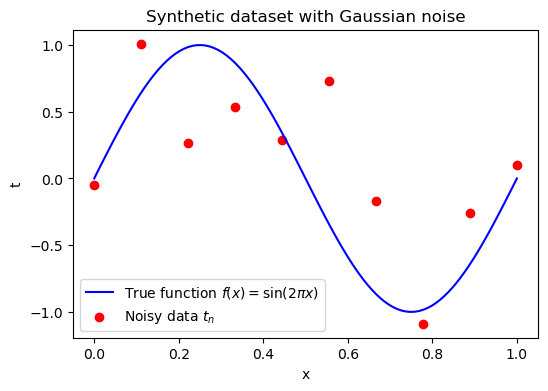

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
from scipy.special import erf
from scipy.stats import gaussian_kde

def func(x):
    return np.sin(2 * np.pi * x) 

def generate_data(err_mu, err_sigma, size=10):
    x = np.linspace(0, 1, size)
    y = func(x) + np.random.normal(err_mu, err_sigma, size)
    return x, y

np.random.seed(2025)

x, t = generate_data(0, 0.5, size=10)

#more smooth true function
x_smooth = np.linspace(0, 1, 100)
y_smooth = func(x_smooth)

plt.figure(figsize=(6,4))
plt.plot(x_smooth, y_smooth, 'b-', label='True function $f(x)=\sin(2\pi x)$')
plt.scatter(x, t, color='r', label='Noisy data $t_n$')
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.title("Synthetic dataset with Gaussian noise")
plt.show()




Base on the generated data, our goal is to exploit this training set in order to make predictions of the value $\widehat{t_n}$ of the target variable for some new value $\widehat{x}$ of the input variable. To achieve this goal in a simple way, we fit the data using a polynomial function of the form
$$y(x, \mathbf{w}) = w_{0} + w_{1}x + w_{2}x^{2} + \dots + w_{M}x^{M} 
= \sum_{j=0}^{M} w_{j} x^{j}$$
which is an linear model of the coefficients $\mathbf{w}$. And in order to determine these coefficients, we shall minimize an error function which is widely used
$$E(\mathbf{w}) = \dfrac{1}{2} \sum_{n = 1}^{N} \left( y(x_n, \mathbf{w}) - t_n \right) $$
The fraction $\dfrac{1}{2}$ is added for later convinience. We can illustrate the error functions by error bars as below.




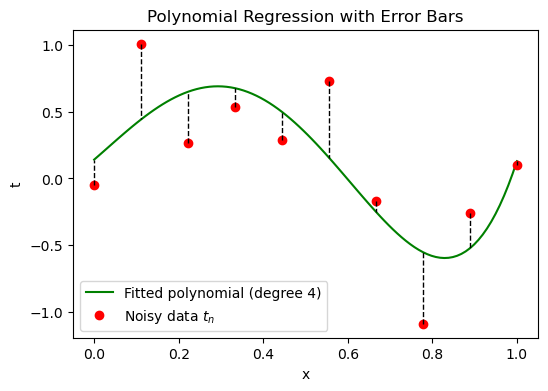

In [3]:
#Plot error bars to true target for degree 4 polynomial

def design_matrix(x, M):
    """ Create the design matrix for polynomial regression of degree M """
    return np.vander(x, N=M+1, increasing=True)

def polynomial_fit(x, t, M):
    """ Fit a polynomial of degree M to the data (x, t) """
    X = design_matrix(x, M)
    w = np.linalg.solve(X.T @ X, X.T @ t)  
    return w

def polynomial_regression(x, t, M):
    """ Predict using the polynomial coefficients w """
    w = polynomial_fit(x, t, M)
    X = design_matrix(x, len(w)-1)
    return w, X @ w

M = 4

w, y_pred = polynomial_regression(x, t, M)

#plot fitted polynomial

#smooth polynomial function
x_smooth = np.linspace(0, 1, 100)
y_smooth = design_matrix(x_smooth, M) @ w


#plot distance from y_pred to true target
plt.figure(figsize=(6,4))
plt.plot(x_smooth, y_smooth, 'g-', label=f'Fitted polynomial (degree {M})')
plt.plot(x, t, 'ro', label='Noisy data $t_n$')
for i in range(len(x)):
    plt.plot([x[i], x[i]], [t[i], y_pred[i]], 'k--', lw=1)
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.title("Polynomial Regression with Error Bars")
plt.show()



However, the choice of $M$ seems to be a practical problem. Since if we choose $M=1,$ our model becomes linear in term of input $x$ and hence can not reflect the structure of the function $f(x) = \sin(2\pi x)$. For above example with $M = 4,$ the shape of the polynomial has some similarities to our target function. When we increase $M$ to $9,$ the error is equal to zero, which is considered an excellent fitted model? However, in fact, the fitted curve fluctuated extremely and does not represent the nature if of the function $f(x) = \sin(2\pi x),$ which is uniform. The ways we choose $M$ can be fall into three situations:

- **Underfitting, e.g $M = 1$:**  
  The model is too simple and cannot capture the oscillatory structure of the target function  
 $f(x) = \sin(2\pi x).$ This situation is known as **underfitting**, where the model fails to represent the data’s essential patterns.

- **Good fit, e.g $M = 4$:**  
  The fitted polynomial begins to resemble the sine curve and reflects the nature of the target function reasonably well.  
  This is considered a good fit, as the model is complex enough to capture the main structure.

- **Overfitting, e.g $M = 9$:**  
  The polynomial interpolates all training points exactly, achieving zero training error. However, the fitted curve oscillates wildly between data points, losing the smooth and uniform nature of $f(x)$. This latter behaviour is known as over-fitting.

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Mai Trung Nguyen\AppData\Local\Temp\ipykernel_15840\3314016095.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_smooth, func(x_smooth), 'b--', label='True function $f(x)=\sin(2\pi x)$')


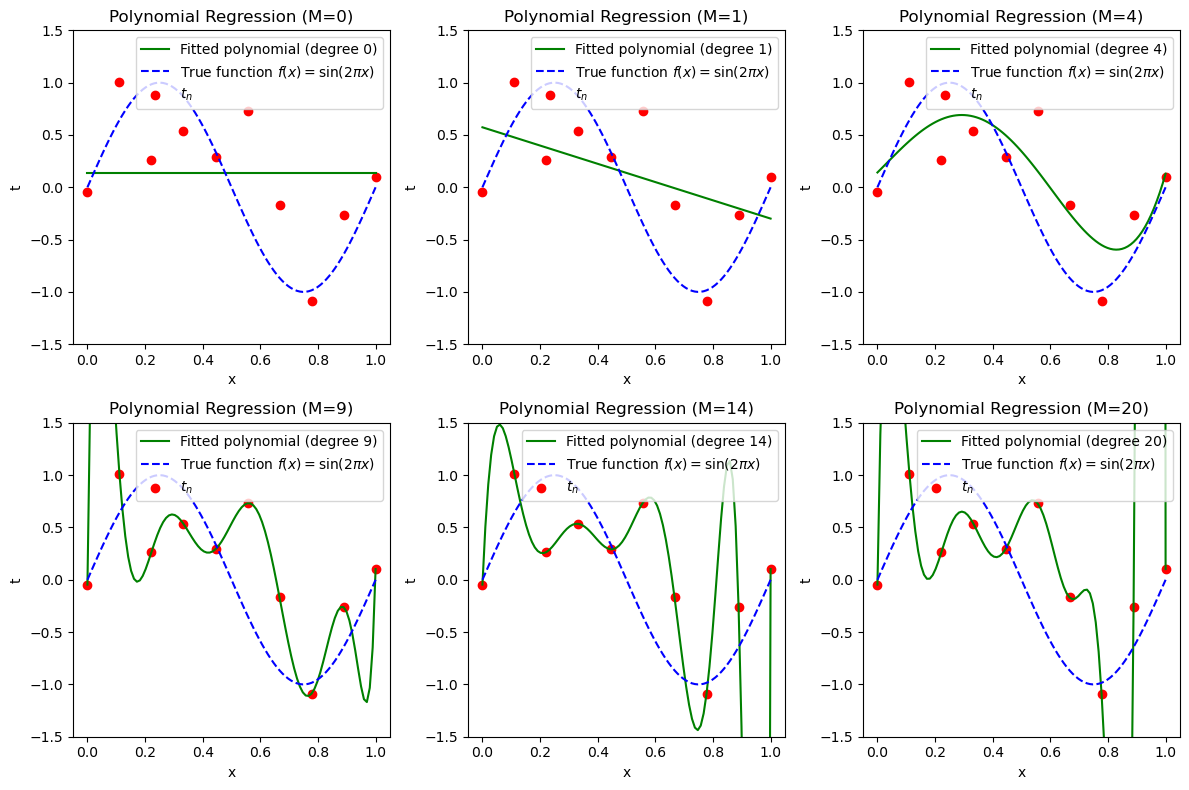

In [4]:
M_list = [0, 1, 4, 9, 14, 20]

plt.figure(figsize=(12, 8))
for i, M in enumerate(M_list):
    w, y_pred = polynomial_regression(x, t, M)
    x_smooth = np.linspace(0, 1, 100)
    y_smooth = design_matrix(x_smooth, M) @ w
    
    plt.subplot(2, 3, i+1)
    plt.plot(x_smooth, y_smooth, 'g-', label=f'Fitted polynomial (degree {M})')
    plt.plot(x_smooth, func(x_smooth), 'b--', label='True function $f(x)=\sin(2\pi x)$')
    plt.scatter(x, t, color='r', label='$t_n$')
    plt.ylim(-1.5, 1.5)
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title(f"Polynomial Regression (M={M})")
plt.tight_layout()
plt.show()

From the figure above, we observe that as $M$ increases, the model becomes more fitted to the noise. This is an undesirable effect, even though the mean squared errors (MSEs) are all zero. To better understand this issue, we can evaluate the models on a separate test set.

Our ultimate goal is to achieve good generalization by making accurate predictions for new data, avoiding under-fitting and over-fitting. We can evaluate the error function $E(t_{test}, w)$ which $t_{test}$ is the test set. But it will be more convinient for us to use the root-mean-square (RMS) error defined by $$E_{RMS} = \sqrt{2E(t_{test}, w)/N}$$ in which the division by N allows us to compare different sizes of data sets on anequal footing, and the square root ensures that $E_{RMS}$ is measured on the same scale (and in the same units)as the target variable $t$.

Degree 0: RMSE = 0.7168, MSE = 0.5570
Degree 1: RMSE = 0.5510, MSE = 0.4824
Degree 2: RMSE = 0.5575, MSE = 0.4773
Degree 3: RMSE = 0.3257, MSE = 0.3710
Degree 4: RMSE = 0.3394, MSE = 0.3554
Degree 5: RMSE = 0.4004, MSE = 0.3273
Degree 6: RMSE = 0.5229, MSE = 0.1783
Degree 7: RMSE = 0.5361, MSE = 0.1519
Degree 8: RMSE = 0.6635, MSE = 0.1109
Degree 9: RMSE = 0.9767, MSE = 0.0001
Degree 10: RMSE = 0.9367, MSE = 0.0000
Degree 11: RMSE = 0.9193, MSE = 0.0000
Degree 12: RMSE = 1.1266, MSE = 0.0000
Degree 13: RMSE = 1.2854, MSE = 0.0000
Degree 14: RMSE = 2.9866, MSE = 0.0000
Degree 15: RMSE = 2.2359, MSE = 0.0000
Degree 16: RMSE = 9.4199, MSE = 0.0000
Degree 17: RMSE = 3.6181, MSE = 0.0000
Degree 18: RMSE = 3.8491, MSE = 0.0000
Degree 19: RMSE = 8.1142, MSE = 0.0000
Degree 20: RMSE = 12.2799, MSE = 0.0000


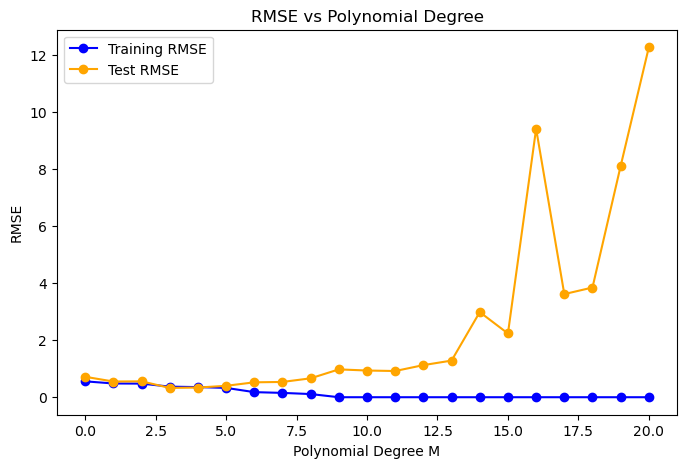

Best model degree: 3


In [5]:

def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def compute_rmse(y_test, y_pred):
    return np.sqrt(compute_mse(y_test, y_pred))


rmse_test_list = []
rmse_train_list = []
M_list = range(21)

x_test = np.linspace(0, 1, 100)
t_test = func(x_test) 

for M in M_list:
    w, y_pred = polynomial_regression(x, t, M)
    rmse_train = compute_rmse(t, y_pred)
    y_pred_test = design_matrix(x_test, M) @ w
    rmse_test = compute_rmse(t_test, y_pred_test)
    rmse_test_list.append(rmse_test)
    rmse_train_list.append(rmse_train)
    print(f"Degree {M}: RMSE = {rmse_test:.4f}, MSE = {rmse_train:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(M_list, rmse_train_list, 'o-', label='Training RMSE',
            color='blue')
plt.plot(M_list, rmse_test_list, 'o-', label='Test RMSE',
            color='orange')
plt.xlabel("Polynomial Degree M")
plt.ylabel("RMSE")
plt.legend()
plt.title("RMSE vs Polynomial Degree")
plt.show()

    
print("Best model degree:", np.argmin(rmse_test_list))

    

As we can see from the plot, the training RMSE decreases as the polynomial degree increases (equals to 0 from M = 9), the model is fitting the training data better. However, the test RMSE initially decreases but then starts to increase after a certain degree, which is overfitting. And degree 3 is the best model with the lowest test RMSE.

Nevertheless, we know that the Taylor series expansion of $f(x) = sin(2\pi x)$ includes all polynomial degrees, so in theory, a degree-20 polynomial should approximate the target function more accurately. The discrepancy arises because we only have 10 training data points. With such a small dataset, the model is more likely to fit the noise rather than the true underlying function.

To demonstrate how the number of data points can affect our model, we can redo the regression with M = 9 on two datasets (x1, t1) and (x2, t2), which has 15 and 100 data points respectively. By increasing the number of training data points, we could reduce the overfitting problem.

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Mai Trung Nguyen\AppData\Local\Temp\ipykernel_15840\3218318607.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_smooth, func(x_smooth), 'b--', label='True function $f(x)=\sin(2\pi x)$')
C:\Users\Mai Trung Nguyen\AppData\Local\Temp\ipykernel_15840\3218318607.py:22: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_smooth, func(x_smooth), 'b--', label='True function $f(x)=\sin(2\pi x)$')


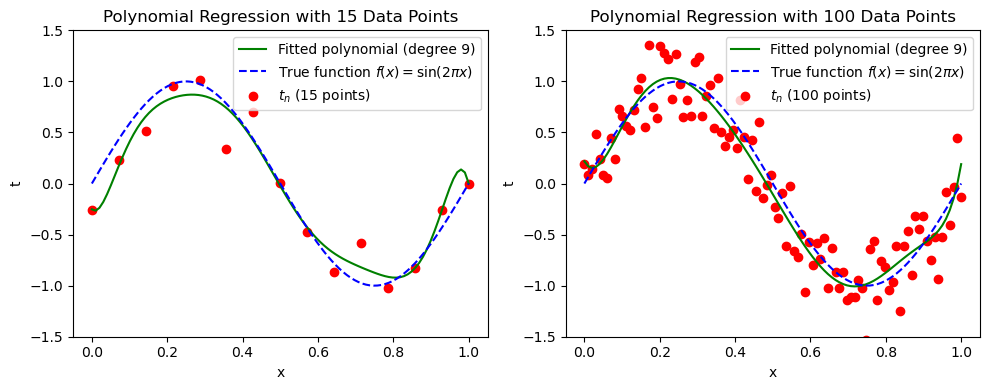

In [6]:
x1, t1 = generate_data(0, 0.25, size=15)
x2, t2 = generate_data(0, 0.25, size=100)

M = 9
# x_smooth = np.linspace(2, 2, 500)
w1, y_pred1 = polynomial_regression(x1, t1, M)
w2, y_pred2 = polynomial_regression(x2, t2, M)
y_smooth1 = design_matrix(x_smooth, M) @ w1
y_smooth2 = design_matrix(x_smooth, M) @ w2
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_smooth, y_smooth1, 'g-', label=f'Fitted polynomial (degree {M})')
plt.plot(x_smooth, func(x_smooth), 'b--', label='True function $f(x)=\sin(2\pi x)$')
plt.scatter(x1, t1, color='r', label='$t_n$ (15 points)')
plt.ylim(-1.5, 1.5)
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.title("Polynomial Regression with 15 Data Points")
plt.subplot(1, 2, 2)
plt.plot(x_smooth, y_smooth2, 'g-', label=f'Fitted polynomial (degree {M})')
plt.plot(x_smooth, func(x_smooth), 'b--', label='True function $f(x)=\sin(2\pi x)$')
plt.scatter(x2, t2, color='r', label='$t_n$ (100 points)')
plt.ylim(-1.5, 1.5)
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.title("Polynomial Regression with 100 Data Points")
plt.tight_layout()
plt.show()



One of the reason of the overfitting is that the coefficients are getting to large values. This make the predicted values oscillate strongly in testing phases. To avoid this, we can add a penalty term for the cofficients into the error function, which will discourage the large coefficient values. The new error function can be written as

$$\tilde{E}(\mathbf{w}) = E(\mathbf{w}) + \dfrac{\lambda}{2} || \mathbb{w}||^2 $$

where $|| \mathbb{w}||^2 \equiv \mathbb{w}^T \mathbb{w} = \sum^{M}_{i = 0} w_i^2.$ Techniques such as this are known in the statistics literature as shrinkage methods because they reduce the value of the coefficients. The particular case of a quadratic regularizer is called ridge regression (Hoerl and Kennard, 1970). In the context of neural networks, this approach is
 known as weight decay.

Note that often the coefficient $w_0$ is omitted from the regularizer because its
 inclusion causes the results to depend on the choice of origin for the target variable
 (Hastie et al., 2001), or it may be included but with its own regularization coefficient
 (we shall discuss this topic in more detail in Section 5.5.1). 

 We now want to find the solution of the ridge regression. We consider the design matrix $X \in \mathbb{R}^{N \times (M+1)}$,  
the target vector $\mathbf{t}\in\mathbb{R}^N$, and  
the weight vector $\mathbf{w}\in\mathbb{R}^{M+1}$.

The ridge-regularized error function is defined as:


$$\tilde{E}(\mathbf{w})
= \frac{1}{2}\|X\mathbf{w}-\mathbf{t}\|^2 + \frac{\lambda}{2}\mathbf{w}^T\mathbf{w},
\qquad \lambda \ge 0.
$$

We can take derivative as
$$\nabla_{\mathbf{w}}\tilde{E}(\mathbf{w})
= X^T(X\mathbf{w}-\mathbf{t}) + \lambda \mathbf{w}.$$


Setting the gradient equal to zero:


$$X^TX\mathbf{w} - X^T\mathbf{t} + \lambda \mathbf{w} = \mathbf{0}.$$

Then we got $(X^TX + \lambda I)\mathbf{w} = X^T\mathbf{t}.$

- If $(X^TX + \lambda I)$ is invertable, we got the solution: $$\mathbf{w}_{\mathrm{ridge}} = (X^TX + \lambda I)^{-1}X^T\mathbf{t}.$$

    - And if $\lambda = 0$, we recover the **ordinary least squares** solution:
    $$\mathbf{w}_{\mathrm{OLS}} = (X^TX)^{-1}X^T\mathbf{t}.
    $$
    - Sometimes the intercept $w_0$ is not penalized.  
    Define the penalty matrix:


    $$L = \mathrm{diag}(0,1,1,\dots,1).$$

    Then the solution becomes:
        $$\mathbf{w} = (X^TX + \lambda L)^{-1}X^T\mathbf{t}.$$

- What if $(X^TX + \lambda I)$ is not invertible?
    - For any nonzero vector $v\in\mathbb{R}^{M+1}$:
        $$
        v^T (X^TX + \lambda I) v = \|Xv\|^2 + \lambda \|v\|^2.
        $$
        If $\lambda>0$ then $\lambda\|v\|^2>0$ for all $v\neq 0$, so
        $$
        v^T (X^TX + \lambda I) v > 0 \quad\text{for all } v\neq 0.
        $$
        Hence $X^TX + \lambda I$ is strictly positive definite and therefore invertible for every $\lambda>0$.  
        So, in theory, ridge regularization (with $\lambda>0$) *resolves* singularity of $X^TX$.
    -  If $\lambda=0$ and $X^TX$ is singular (e.g., perfect multicollinearity or more features than samples), the OLS formula $(X^TX)^{-1}X^T t$ can not be derived. We can use the Moore–Penrose pseudoinverse instead:
  $$
  w_{\text{OLS}} = X^\dagger t.
  $$
    We can use Singular Value Decomposition (SVD) to compute in this scenario. Write the thin SVD of $X$ as $X = U S V^T$ (with singular values $s_i\ge 0$). Then
$$
X^TX = V S^2 V^T,
$$
and the ridge solution can be written without forming inverses of ill-conditioned matrices:
$$
w_{\text{ridge}}
= (X^TX + \lambda I)^{-1}X^T t
= V \mathrm{diag}\!\Big(\frac{s_i}{s_i^2 + \lambda}\Big) U^T t.
$$
This formula is numerically stable: each singular component is scaled by $s_i/(s_i^2+\lambda)$. When $s_i$ is tiny, the factor becomes small. 

For a more detailed look into SVD, we start with the solution for the ridge regression weights:
    $$\mathbf{w}_{\mathrm{ridge}} = (X^TX + \lambda I)^{-1}X^T\mathbf{t}$$
And the thin SVD of $X$ is given by $X = USV^T$. From this, we can derive the transposes:
      $$X^T = (USV^T)^T = V S U^T$$
      $$X^TX = (V S U^T)(U S V^T) = V S (U^T U) S V^T.$$
    
Since the columns of $U$ are orthonormal, $U^T U = I$ (the identity matrix). Therefore, $$X^TX = V S^2 V^T$$

Now we replace $X^TX$ and $X^T$ in the original equation*:
    $$\mathbf{w}_{\mathrm{ridge}} = (V S^2 V^T + \lambda I)^{-1} (V S U^T) \mathbf{t}$$

We can rewrite the identity matrix as $I = VIV^T$ to factor out the $V$ matrices.
       $$(V S^2 V^T + \lambda VIV^T)^{-1}$$
      $$= (V(S^2 + \lambda I)V^T)^{-1}$$

 Using the property $(ABC)^{-1} = C^{-1}B^{-1}A^{-1}$, and knowing that for an orthogonal matrix $V^{-1}=V^T$, we get:
      $$= (V^T)^{-1}(S^2 + \lambda I)^{-1}V^{-1} = V(S^2 + \lambda I)^{-1}V^T$$
Then, we get
  $$\mathbf{w}_{\mathrm{ridge}} = \left[ V(S^2 + \lambda I)^{-1}V^T \right] (V S U^T) \mathbf{t}$$
    
Since $V^T V = I$, the expression simplifies:

$$\mathbf{w}_{\mathrm{ridge}} = V(S^2 + \lambda I)^{-1} (V^T V) S U^T \mathbf{t}$$
    
$$\mathbf{w}_{\mathrm{ridge}} = V(S^2 + \lambda I)^{-1} S U^T \mathbf{t}$$

The term $(S^2 + \lambda I)^{-1} S$ is a diagonal matrix. If $s_i$ is the $i$-th singular value on the diagonal of $S$, then the corresponding diagonal entry in this new matrix is $\frac{s_i}{s_i^2 + \lambda}$. This leads to the final, computationally stable formula:
$$\mathbf{w}_{\mathrm{ridge}} = V \mathrm{diag}\left(\frac{s_i}{s_i^2 + \lambda}\right) U^T \mathbf{t}$$
 
 To show the impact of regularization term, we can illustrate the fitted curve with varied $\lambda.$ Its effect also controls the effective complexity of the model and hence determines the degree of over-fitting, which can be seen through the RMSE plot.




Lambda=1.52e-08, MSE with regularization: 0.1047
Lambda=1.00e+00, MSE with regularization: 0.5143
Lambda=0.00e+00, MSE without regularization: 0.0001


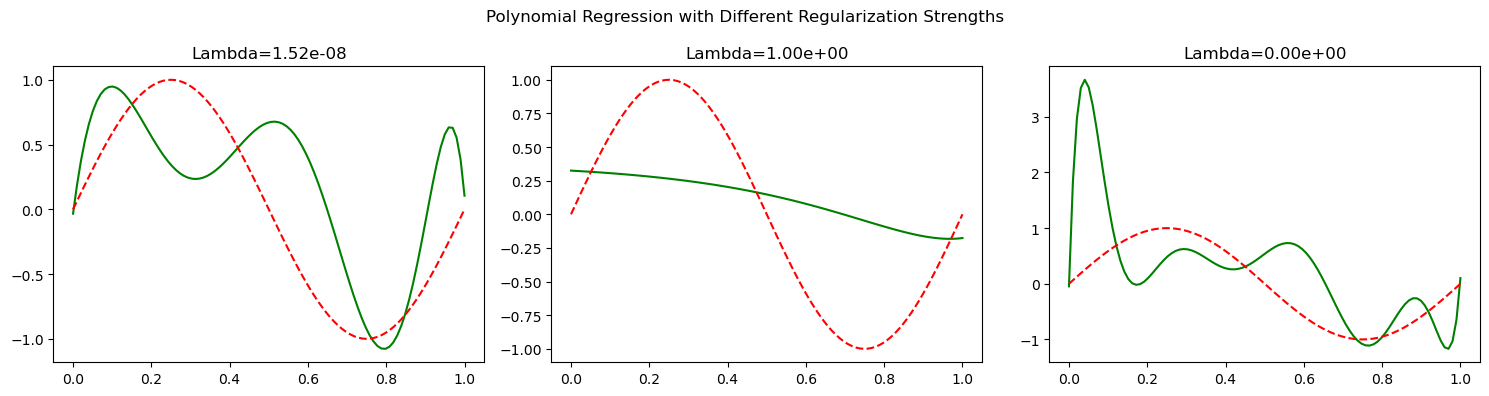

   Degree  Lambda=1.52e-08  Lambda=1.00e+00  Lambda=0.00e+00
0       0        -0.034144         0.324716        -0.046193
1       1        23.669710        -0.162110       231.391116
2       2      -179.775812        -0.249038     -4844.293710
3       3       438.789393        -0.201645     41177.440379
4       4      -231.555613        -0.129064   -185743.223501
5       5      -263.784398        -0.057672    490158.513356
6       6       -75.740940         0.005045   -780730.516332
7       7       266.202374         0.057572    737943.538784
8       8       379.440426         0.100516   -380714.292208
9       9      -357.106090         0.135176     82521.590836


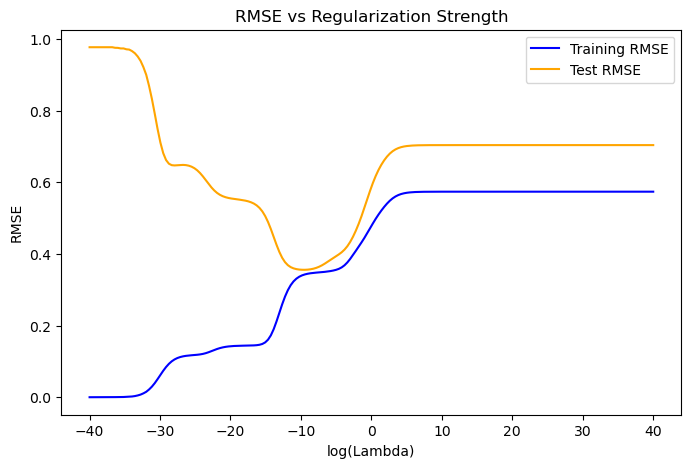

Comparing weights for lambda = 1.52e-08

   Normal Method  SVD Method    Difference
0      -0.034144   -0.034144 -3.575733e-11
1      23.669710   23.669710  2.635119e-09
2    -179.775812 -179.775812  1.312520e-08
3     438.789393  438.789393 -3.946429e-07
4    -231.555613 -231.555615  1.926231e-06
5    -263.784398 -263.784395 -3.341638e-06
6     -75.740940  -75.740941  3.900478e-07
7     266.202374  266.202368  5.484081e-06
8     379.440426  379.440433 -6.171132e-06
9    -357.106090 -357.106092  2.091329e-06

Max absolute difference in weights:  6.171132383769873e-06


In [7]:
def mse_regularization(y_true, y_pred, lambda_, w):
    mse = np.mean(np.abs(y_true - y_pred))
    reg = lambda_/2 * np.sum(np.square(w))
    return mse + reg

def ridge_regression(x, t, M, lambda_):
    """ Fit a polynomial of degree M to the data (x, t) with L2 regularization """
    X = design_matrix(x, M)
    I = np.eye(M+1)
    w = np.linalg.solve(X.T @ X + lambda_ * I, X.T @ t)  
    y_pred = X @ w
    return w, y_pred


lambda_1 = np.exp(-18)
lambda_2 = np.exp(0)
lambda_3 = 0
M = 9
w1, y_pred1 = ridge_regression(x, t, M, lambda_1)
mse1 = mse_regularization(t, y_pred1, lambda_1, w1)
w2, y_pred2 = ridge_regression(x, t, M, lambda_2)
mse2 = mse_regularization(t, y_pred2, lambda_2, w2)
w3, y_pred3 = ridge_regression(x, t, M, lambda_3)
mse3 = mse_regularization(t, y_pred3, lambda_3, w3)


print(f"Lambda={lambda_1:.2e}, MSE with regularization: {mse1:.4f}")
print(f"Lambda={lambda_2:.2e}, MSE with regularization: {mse2:.4f}")
print(f"Lambda={lambda_3:.2e}, MSE without regularization: {mse3:.4f}")

#plot fitted polynomial with different lambda
x_smooth = np.linspace(0, 1, 100)
y_smooth1 = design_matrix(x_smooth, M) @ w1
y_smooth2 = design_matrix(x_smooth, M) @ w2
y_smooth3 = design_matrix(x_smooth, M) @ w3
Y_smooth_true = func(x_smooth)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(x_smooth, y_smooth1, 'g-', label=f'Fitted polynomial (degree {M})')
plt.plot(x_smooth, Y_smooth_true, 'r--', label='True function')
plt.title(f'Lambda={lambda_1:.2e}')
plt.subplot(1, 3, 2)
plt.plot(x_smooth, y_smooth2, 'g-', label=f'Fitted polynomial (degree {M})')
plt.plot(x_smooth, Y_smooth_true, 'r--', label='True function')
plt.title(f'Lambda={lambda_2:.2e}')
plt.subplot(1, 3, 3)
plt.plot(x_smooth, y_smooth3, 'g-', label=f'Fitted polynomial (degree {M})')
plt.plot(x_smooth, Y_smooth_true, 'r--', label='True function')
plt.title(f'Lambda={lambda_3:.2e}')
plt.suptitle("Polynomial Regression with Different Regularization Strengths")
plt.tight_layout()
plt.show()

#table of coefficients
import pandas as pd
coeff_df = pd.DataFrame({
    'Degree': range(M+1),
    f'Lambda={lambda_1:.2e}': w1,
    f'Lambda={lambda_2:.2e}': w2,
    f'Lambda={lambda_3:.2e}': w3
})
print(coeff_df)

#multiple lambdas
ln_lambda_list = np.linspace(-40, 40, 200)
rmse_train_list = []
rmse_test_list = []
M = 9
for ln_lambda_ in ln_lambda_list:
    lambda_ = np.exp(ln_lambda_)
    w, y_pred = ridge_regression(x, t, M, lambda_)
    rmse_train = compute_rmse(t, y_pred)
    y_pred_test = design_matrix(x_test, M) @ w
    rmse_test = compute_rmse(t_test, y_pred_test)
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)
    
plt.figure(figsize=(8, 5))
plt.plot(ln_lambda_list, rmse_train_list, '-', label='Training RMSE',
            color='blue')
plt.plot(ln_lambda_list, rmse_test_list, '-', label='Test RMSE',
            color='orange')
plt.xlabel("log(Lambda)")
plt.ylabel("RMSE")
plt.legend()
plt.title("RMSE vs Regularization Strength")
plt.show()



def ridge_regression_svd(x, t, M, lambda_):
    X = design_matrix(x, M)
    
    U, s_diag, VT = np.linalg.svd(X, full_matrices=False)
    V = VT.T


    scaling_factors = s_diag / (s_diag**2 + lambda_)

    w = V @ np.diag(scaling_factors) @ U.T @ t
    
    y_pred = X @ w
    return w, y_pred

#compare with previous ridge regression
w_normal, y_pred_normal = ridge_regression(x, t, M, lambda_1)
w_svd, y_pred_svd = ridge_regression_svd(x, t, M, lambda_1)
print("Comparing weights for lambda = {:.2e}\n".format(lambda_1))
comparison_df = pd.DataFrame({
    'Normal Method': w_normal,
    'SVD Method': w_svd,
    'Difference': w_normal - w_svd
})
print(comparison_df)
print("\nMax absolute difference in weights: ", np.max(np.abs(w_normal - w_svd)))



In this scenario, we can choose lambda around $exp(-10)$ which gives the best generalization and pretty well fits the training set.

So far our discussion of polynomial curve fitting has appealed largely to intuition. We now seek a more principled approach to solving problems in pattern recognition by turning to a discussion of probability theory. As well as providing the foundation for nearly all of the subsequent developments in this book, it will also give us some important insights into the concepts we have introduced in the context of polynomial curve fitting and will allow us to extend these to more complex situations.

# 1.2 Probability Theory

## The rule of sum and product
The first part of the section is mainly concerned with the fundamental rules of probability:
- Sum rule: $$p(X) = \sum_Y p(x, y) $$
- Product rule: $$p(X, Y) = p(Y|X)p(X)$$

Here, p(x, Y) is the joint probability of X and Y, p(Y|X) is the conditional probability of Y given X, and p(X) is the marginal probability of X. And we also got the symmetric form:
$p(X, Y) = p(Y, X)$.

Bayes' theorem is derived from the product rule:
$$p(Y|X) = \frac{p(X|Y)p(Y)}{p(X)}$$

Using sum rule, we can write the denominator as:
$$p(X) = \sum_Y p(X|Y)p(Y)$$
Hence, Bayes' theorem can be written as:
$$p(Y|X) = \frac{p(X|Y)p(Y)}{\sum_Y p(X|Y)p(Y)}$$

# 1.2.1 Probability densities

If the probability of a real-valued variable $x$ falling in the interval $(x, x + \delta x)$ is given by $p(x)\delta x$ for $\delta x \to 0$, then $p(x)$ is called the probability density over $x$. This is illustrated in Figure 1.12. The probability that $x$ will lie in an interval $(a, b)$ is then given by
\begin{equation*}
    p(x \in (a, b)) = \int_a^b p(x)\, dx.
\end{equation*}

Probability density function p(x) must satisfy the following two conditions:
1. p(x) ≥ 0 for all x.
2. The total area under the curve of p(x)  equal 1, or
   \begin{equation*}
   \int_{-\infty}^{\infty} p(x)\, dx = 1.
   \end{equation*}

Probability of x in [a, b] is given by
\begin{equation*}
P(a \leq x \leq b) = \int_{a}^{b} p(x)\, dx.
\end{equation*}
And the cumulative distribution function (CDF) and is denoted by
\begin{equation*}
F(z) = P(X \leq z) = \int_{-\infty}^{z} p(x)\, dx.
\end{equation*}

Notably, under a nonlinear change of variable, a probability density transforms differently from a simple function, due to the Jacobian factor. For instance, if we consider a change of variables $x = g(y)$, then a function $f(x)$ becomes $\tilde{f}(y) = f(g(y))$. Now consider a probability density $p_x(x)$ that corresponds to a density $p_y(y)$ with respect to the new variable $y$, where the suffices denote the fact that $p_x(x)$ and $p_y(y)$ are different densities. Observations falling in the range $(x, x + \delta x)$ will, for small values of $\delta x$, be transformed into the range $(y, y + \delta y)$ where $p_x(x)\delta x \simeq p_y(y)\delta y$, and hence

\begin{align*}
    p_y(y) &= p_x(x) \left| \frac{dx}{dy} \right| \nonumber \\
           &= p_x(g(y)) \left| g'(y) \right| .
\end{align*}


# 1.2.2 Expectation, Variance and Covariance

The average or mean of a function $f(x)$ under a probability distribution $p(x)$ is given by the expectation operator, defined as
1. For discrete variables
   \begin{equation*}
   \mathbb{E}[f] = \sum_x p(x) f(x).
   \end{equation*}

2. For continuous variables

    \begin{equation*}
    \mathbb{E}[f] = \int p(x) f(x)\, dx.
    \end{equation*}

We can approximate the expectation using Monte Carlo integration. If we draw $N$ independent samples $\{x_n\}$ from the distribution $p(x)$, then the expectation can be approximated as

\begin{equation*}
\mathbb{E}[f] \approx \frac{1}{N} \sum_{n=1}^{N} f(x_n).
\end{equation*}

We can approximate the expectation using Monte Carlo integration. If we draw $N$ independent samples $\{x_n\}$ from the distribution $p(x)$, then the expectation can be approximated as

\begin{equation*}
\mathbb{E}[f] \approx \frac{1}{N} \sum_{n=1}^{N} f(x_n).
\end{equation*}

If we have a function of two variables, $f(x, y)$, and a joint distribution $p(x, y)$, then the expectation is given by
\begin{equation*}
\mathbb{E}[f] = \int \int p(x, y) f(x, y)\, dx\, dy.
\end{equation*}

Or we can denote which variable we are taking expectation over by
\begin{equation*}
\mathbb{E}_x[f(x, y)] = \int p(x) f(x, y)\, dx.
\end{equation*}

Conditional expectation is defined as
\begin{equation*}
\mathbb{E}_x[f(x) | y] = \int p(x | y) f(x)\, dx.
\end{equation*}


The variance of $f(x)$ is defined as
\begin{equation*}
\text{Var}[f] = \mathbb{E}[(f(x) - \mathbb{E}[f])^2] = \mathbb{E}[f(x)^2] - (\mathbb{E}[f])^2.
\end{equation*}

If $f(x) = x$, then the variance of $x$ is given by
\begin{equation*}
\text{Var}[x] = \mathbb{E}[x^2] - (\mathbb{E}[x])^2.
\end{equation*}
For two variables $x$ and $y$, the covariance is defined as
\begin{equation*}
\text{Cov}[x, y] = \mathbb{E}[(x - \mathbb{E}[x])(y - \mathbb{E}[y])] = \mathbb{E}[xy] - \mathbb{E}[x]\mathbb{E}[y].
\end{equation*}
Note that, if $x$ and $y$ are independent, then $\text{Cov}[x, y] = 0$.

If we have a vector of variables $\mathbf{x} = (x_1, x_2, \ldots, x_D)^T$, then the covariance matrix is defined as
\begin{equation*}
\text{Cov}[\mathbf{x}] = \mathbb{E}[(\mathbf{x} - \mathbb{E}[\mathbf{x}])(\mathbf{x} - \mathbb{E}[\mathbf{x}])^T].
\end{equation*}
With 2 vectors $\mathbf{x}$ and $\mathbf{y}$, the cross-covariance matrix is defined as
\begin{equation*}
\text{Cov}[\mathbf{x}, \mathbf{y}] = \mathbb{E}[(\mathbf{x} - \mathbb{E}[\mathbf{x}])(\mathbf{y} - \mathbb{E}[\mathbf{y}])^T].
\end{equation*}

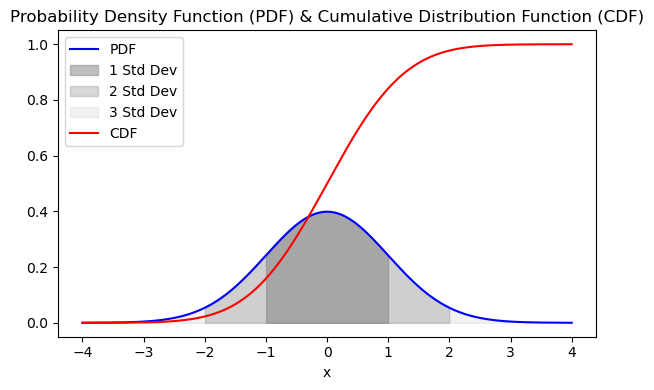

In [8]:
#probability density and cumulative distribution functions illustration
mu, sigma = 0, 1  # mean and standard deviation
x = np.linspace(mu - 4*sigma, mu + 4*sigma,
                1000)
pdf = norm.pdf(x, mu, sigma)
cdf = norm.cdf(x, mu, sigma)
plt.figure(figsize=(6, 4))
plt.plot(x, pdf, 'b-', label='PDF')
plt.fill_between(x, pdf, where=(x > mu - sigma) & (x <
    mu + sigma), color='gray', alpha=0.5, label='1 Std Dev')
plt.fill_between(x, pdf, where=(x > mu - 2*sigma) & (x <
    mu + 2*sigma), color='gray', alpha=0.3, label
='2 Std Dev')
plt.fill_between(x, pdf, where=(x > mu - 3*sigma) &
    (x < mu + 3*sigma), color='gray', alpha=0.1, label
='3 Std Dev')
plt.title('Probability Density Function (PDF) & Cumulative Distribution Function (CDF)')
plt.xlabel('x')
plt.legend()
plt.plot(x, cdf, 'r-', label='CDF')
plt.xlabel('x')
plt.legend()
plt.tight_layout()
plt.show()

# 1.2.3 Bayesian Probability

In Bayesian probability, we treat probability as a degree of belief or certainty about an event, rather than a long-run frequency of occurrence. We can then describe our uncertainty about a parameter $\theta$ using a probability distribution $p(\theta)$, known as the prior distribution. When we observe data $D$, we can update our beliefs about $\theta$ using Bayes' theorem:
    
\begin{equation*}
p(\theta | D) = \frac{p(D | \theta) p(\theta)}{p(D)},
\end{equation*}
where $p(\theta | D)$ is the posterior distribution, $p(D | \theta)$ is the likelihood, and $p(D)$ is the marginal likelihood or evidence. Or we can state Bayes' theorem in words:
\begin{equation*}
\text{Posterior} \propto \text{Likelihood} \times \text{Prior}.
\end{equation*}

One advantage of the Bayesian approach is that it allows us to incorporate prior knowledge or beliefs about the parameters into our analysis. However, the choice of prior can be subjective and may influence the results. In practice, we often use conjugate priors, which are chosen such that the posterior distribution is in the same family as the prior distribution, making the calculations more tractable. But this seem to be selected for mathematical convenience rather than reflecting true prior beliefs. 

Reducing the influence of the prior is one motivation for so-called non-informative priors, which are designed to have minimal impact on the posterior distribution. 

Bayesian methods can be computationally intensive, especially for complex models or large datasets, as they often require integration over high-dimensional parameter spaces. Techniques such as Markov Chain Monte Carlo (MCMC) and variational inference are commonly used to approximate the posterior distribution in such cases. The book will discuss these methods in chapter 11.

# 1.2.4 The Gaussian Distribution
 
 The Gaussian distribution is defined as
\begin{equation*}
\mathcal{N}(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right),
\end{equation*}
where $\mu$ is the mean and $\sigma^2$ is the variance. The Gaussian distribution is symmetric around the mean.

The square of the standard deviation, $\sigma^2$, and $\beta = 1/\sigma^2$ is known as the precision. The Gaussian distribution has several important properties:
1. The mean, median, and mode are all equal to $\mu$. Or we can write as:

    \begin{equation*}
    \mathbb{E}[x] = \int \mathcal{N}(x | \mu, \sigma^2) \, dx = \mu.
    \end{equation*}

2. Second order moment is given by

    \begin{equation*}
    \mathbb{E}[x^2] = \int x^2 \mathcal{N}(x | \mu, \sigma^2) \, dx = \mu^2 + \sigma^2.
    \end{equation*}

3. The variance is given by

    \begin{equation*}
    \text{Var}[x] = \int (x - \mu)^2 \mathcal{N}(x | \mu, \sigma^2) \, dx = \sigma^2.
    \end{equation*}

Skewed Gaussian distribution is a generalization of the Gaussian distribution that allows for skewness. It is defined as
\begin{equation*}
\text{SG}(x | \xi, \omega, \alpha) = \frac{2}{\omega} \phi\left(\frac{x - \xi}{\omega}\right) \Phi\left(\alpha \frac{x - \xi}{\omega}\right),
\end{equation*}
where $\phi(x)$ is the standard normal PDF, $\Phi(x)$ is the standard normal CDF, $\xi$ is the location parameter, $\omega$ is the scale parameter, and $\alpha$ is the shape parameter. When $\alpha = 0$, the skewed Gaussian reduces to the standard Gaussian distribution.

With vector variables, the multivariate Gaussian distribution is defined as
\begin{equation*}
\mathcal{N}(\mathbf{x} | \boldsymbol{\mu}, \mathbf{\Sigma}) = \frac{1}{(2\pi)^{k/2} |\mathbf{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})\right),
\end{equation*}
where $\mathbf{x}$ is a $k$-dimensional vector, $\boldsymbol{\mu}$ is the mean vector, and $\mathbf{\Sigma}$ is the covariance matrix. The covariance matrix must be positive definite and symmetric.


With a data set of $N$ observations $\{\mathbf{x}_n\}$, the probability of the data set is given by
\begin{equation}
p(\mathbf{X} | \boldsymbol{\mu}, \mathbf{\Sigma}) = \prod_{n=1}^{N} \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}, \mathbf{\Sigma}).
\tag{1.2.4.1}
\end{equation}
This is known as the likelihood function. To determine the parameters $\boldsymbol{\mu}$ and $\mathbf{\Sigma}$, we shall maximize the likelihood function. It is a litte bit strange when we are maximizing the probability of the data set given the parameters to determine the parameters. But this is a common approach in statistics known as maximum likelihood estimation (MLE). 

We then take the logarithm of the likelihood function to obtain the log-likelihood function, which makes the mathematical manipulation easier and later on the numerical computation more stable. The log-likelihood function is given by
\begin{equation*}
\ln p(\mathbf{X} | \boldsymbol{\mu}, \mathbf{\Sigma}) = -\frac{N}{2} \ln(2\pi) - \frac{N}{2} \ln|\mathbf{\Sigma}| - \frac{1}{2} \sum_{n=1}^{N} (\mathbf{x}_n - \boldsymbol{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{x}_n - \boldsymbol{\mu}).
\end{equation*}

Solving for the parameters that maximize the log-likelihood function, we obtain the maximum likelihood estimates for the mean and variance:
\begin{align*}
\boldsymbol{\mu}_{ML} &= \frac{1}{N} \sum_{n=1}^{N} \mathbf{x}_n, \\
\mathbf{\Sigma}_{ML} &= \frac{1}{N} \sum_{n=1}^{N} (\mathbf{x}_n - \boldsymbol{\mu}_{ML})(\mathbf{x}_n - \boldsymbol{\mu}_{ML})^T.
\end{align*}

The expected values of the maximum likelihood estimates are given by
\begin{align*}
\mathbb{E}[\boldsymbol{\mu}_{ML}] &= \boldsymbol{\mu}, \\
\mathbb{E}[\mathbf{\Sigma}_{ML}] &= \frac{N-1}{N} \mathbf{\Sigma}.
\end{align*}

Therefore, the unbiased estimator for the covariance matrix is given by
\begin{equation*}
\mathbf{\Sigma}_{unbiased} = \frac{1}{N-1} \sum_{n=1}^{N} (\mathbf{x}_n - \boldsymbol{\mu}_{ML})(\mathbf{x}_n - \boldsymbol{\mu}_{ML})^T.
\end{equation*}

When we consider univariate Gaussian distribution, the maximum likelihood estimates for the mean and variance reduce to
\begin{align*}
\mu_{ML} &= \frac{1}{N} \sum_{n=1
}^{N} x_n, \\
\sigma^2_{ML} &= \frac{1}{N} \sum_{n=1}^{N} (x_n - \mu_{ML})^2.
\end{align*}



# 1.2.5 Curve Fitting Revisited

Now we consider a probabilistic view of the curve fitting problem. We express the uncertainty in the target variable $t$ by a probability distribution. We assume that, given the value of $x$, the target variable $t$ is distributed according to a Gaussian distribution:
\begin{equation*}
p(t | x, \mathbf{w}, \beta) = \mathcal{N}(t | y(x, \mathbf{w}), \beta^{-1}),
\end{equation*}
where $y(x, \mathbf{w})$ is the value of the polynomial function at $x$ with parameters $\mathbf{w}$, and $\beta$ is the precision of the Gaussian noise.

We now want to find the parameters $\mathbf{w}$ that maximize the likelihood of the data given the model. The likelihood function is given by
\begin{equation*}
p(\mathbf{t} | \mathbf{X}, \mathbf{w}, \beta) = \prod_{n=1}^{N} p(t_n | x_n, \mathbf{w}, \beta) = \prod_{n=1}^{N} \mathcal{N}(t_n | y(x_n, \mathbf{w}), \beta^{-1}).
\end{equation*}
Taking the logarithm of the likelihood function, we obtain the log-likelihood function:
\begin{equation*}   
\ln p(\mathbf{t} | \mathbf{X}, \mathbf{w}, \beta) = -\frac{N}{2} \ln(2\pi) + \frac{N}{2} \ln \beta - \frac{\beta}{2} \sum_{n=1}^{N} (t_n - y(x_n, \mathbf{w}))^2.
\end{equation*}

Consider the maximum likelihood estimate of the parameters $\mathbf{w}$ by maximizing the log-likelihood function. Since the last two terms are not dependent on $\mathbf{w}$, we can ignore them when maximizing the log-likelihood. This is equivalent to minimizing the sum-of-squares error function:
\begin{equation*}
E_D(\mathbf{w}) = \frac{1}{2} \sum_{n=1}^{N} (t_n - y(x_n, \mathbf{w}))^2.
\end{equation*}

We consider the maximum likelihood estimate of the precision parameter $\beta$. Taking the derivative of the log-likelihood function with respect to $\beta$ and setting it to zero, we obtain
\begin{equation*}
\frac{\partial}{\partial \beta} \ln p(\mathbf{t} | \mathbf{X}, \mathbf{w}, \beta) = \frac{N}{2\beta} - \frac{1}{2} \sum_{n=1}^{N} (t_n - y(x_n, \mathbf{w}))^2 = 0.
\end{equation*}
Solving for $\beta$, we obtain the maximum likelihood estimate:
\begin{equation*}
\beta_{ML} = \frac{N}{\sum_{n=1}^{N} (t_n - y(x_n, \mathbf{w}))^2}.
\end{equation*}

We can make predictions for new input values $x$ using the predictive distribution:
\begin{equation*}
p(t | x, \mathbf{X}, \mathbf{t}, \beta_{ML}) = \mathcal{N}(t | y(x, \mathbf{w}_{ML}), \beta_{ML}^{-1}),
\end{equation*}

Now, we consider a more Bayesian approach to the curve fitting problem. We place a prior distribution over the parameters $\mathbf{w}$:
\begin{equation*}
p(\mathbf{w} | \alpha) = \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}),
\end{equation*}
where $\alpha$ is the precision of the prior distribution, and $\mathbf{I}$ is the identity matrix.

Using the Bayes' theorem, we can combine the prior distribution with the likelihood function to obtain the posterior distribution over the parameters $\mathbf{w}$:
\begin{equation*}
p(\mathbf{w} | \mathbf{X}, \mathbf{t}, \beta) \propto p(\mathbf{t} | \mathbf{X}, \mathbf{w}, \beta) p(\mathbf{w} | \alpha).
\end{equation*}

This technique is known as maximum a posteriori (MAP) estimation. The MAP estimate of the parameters $\mathbf{w}$ is given by
\begin{equation*}
\mathbf{w}_{MAP} = \arg \max_{\mathbf{w}} p(\mathbf{w} | \mathbf{X}, \mathbf{t}, \beta).
\end{equation*}

Taking negative logarithm of the posterior distribution, we obtain the negative log-posterior:
\begin{equation*}
-\ln p(\mathbf{w} | \mathbf{X}, \mathbf{t},
    \beta) = \frac{\beta}{2} \sum_{n=1}^{N} (t_n - y(x_n, \mathbf{w}))^2 + \frac{\alpha}{2} \mathbf{w}^T \mathbf{w} + \text{const}.
\end{equation*}

Minimizing the negative log-posterior is equivalent to minimizing the regularized sum-of-squares error function:
\begin{equation*}
E_{MAP}(\mathbf{w}) = \frac{1}{2} \sum_{n=1}^{N} (t_n - y(x_n, \mathbf{w}))^2 + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}.
\end{equation*}
where $\lambda = \alpha / \beta$ is the regularization parameter.



# 1.2.6 Bayesian Curve Fitting

We still made a point estimate of the parameters $\mathbf{w}$ using MAP estimation. In a fully Bayesian approach, we consider the entire posterior distribution over the parameters $\mathbf{w}$ instead of a single point estimate. Such marginalization lie at the heart of Bayesian methods.

A Bayesian treatment involves an application of sum and product rules to integrate over all possible values of the parameters $\mathbf{w}$. We shall ommit the dependence on $\alpha$ and $\beta$ for simplicity. The predictive distribution for a new input value $x$ is given by
\begin{equation*}
p(t | x, \mathbf{X}, \mathbf{t}) = \int p(t | x, \mathbf{w}) p(\mathbf{w} | \mathbf{X}, \mathbf{t}) d\mathbf{w}.
\end{equation*}

In later section 3.3 we will see the integral can be evaluated analytically when the prior distribution is Gaussian. The resulting predictive distribution is also Gaussian as:
\begin{equation*}
p(t | x, \mathbf{X}, \mathbf{t}) = \mathcal{N}(t | m(x), s^2(x)),
\end{equation*}
where the predictive mean $m(x)$ and variance $s^2(x)$ are given by
\begin{align*}
m(x) & = \beta \boldsymbol{\phi}(x)^T \mathbf{S} \boldsymbol{\Phi}^T \mathbf{t}, \\
s^2(x) & = \beta^{-1} + \boldsymbol{\phi}(x)^T \mathbf{S} \boldsymbol{\phi}(x),
\end{align*}
with $\mathbf{S} = (\alpha \mathbf{I} + \beta \boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1}$. Here, $\boldsymbol{\Phi}$ is the design matrix for the training inputs $\mathbf{X}$, and $\boldsymbol{\phi}(x)$ is the basis function vector for the new input $x$ with elements $\phi_j(x) = x^j$ for $j = 0, \ldots, M$.




<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Mai Trung Nguyen\AppData\Local\Temp\ipykernel_15840\3574479981.py:35: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_smooth, func(x_smooth), 'b--', label='True functio$f(x)=\sin(2\pi x)$')


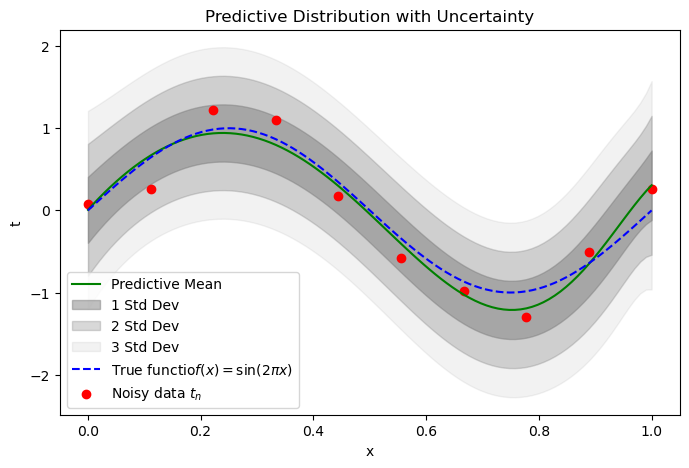

In [9]:
#predictive distribution illustration

def predictive_distribution(x_new, x_train, t_train, M, beta, alpha):
    """ Compute the predictive mean and variance at x_new """
    X_train = design_matrix(x_train, M)
    X_new = design_matrix(x_new, M)
    
    S_N_inv = alpha * np.eye(M+1) + beta * X_train.T @ X_train
    S_N = np.linalg.inv(S_N_inv)
    
    m_N = beta * S_N @ X_train.T @ t_train
    
    predictive_mean = X_new @ m_N
    predictive_variance = 1/beta + np.sum(X_new @ S_N * X_new, axis=1)
    
    return predictive_mean, predictive_variance

M = 9
alpha = 0.005
beta = 11.1
x_new = np.linspace(0, 1, 100)
x = np.linspace(0, 1, 10)
t = func(x) + np.random.normal(0, 0.25, len(x))

predictive_mean, predictive_variance = predictive_distribution(x_new, x, t, M, beta, alpha)
std_dev = np.sqrt(predictive_variance)
plt.figure(figsize=(8, 5))
plt.plot(x_new, predictive_mean, 'g-', label='Predictive Mean')
plt.fill_between(x_new, predictive_mean - std_dev, predictive_mean + std_dev,
                    color='gray', alpha=0.5, label='1 Std Dev')
plt.fill_between(x_new, predictive_mean - 2*std_dev, predictive_mean + 2*std_dev,
                    color='gray', alpha=0.3, label='2 Std Dev')
plt.fill_between(x_new, predictive_mean - 3*std_dev, predictive_mean +
                    3*std_dev, color='gray', alpha=0.1, label='3 Std Dev')
plt.plot(x_smooth, func(x_smooth), 'b--', label='True functio$f(x)=\sin(2\pi x)$')
plt.scatter(x, t, color='r', label='Noisy data $t_n$')
plt.xlabel("x")
plt.ylabel("t")
plt.title("Predictive Distribution with Uncertainty")
plt.legend()
plt.show()


# 1.3 Model Selection



In this section, cross-validation is introduced. The basic idea is to divide the dataset into several subsets, train the model on some subsets, and validate it on the remaining subset. This process is repeated multiple times to ensure that each subset serves as a validation set once. The average performance across all iterations provides a robust estimate of the model's generalization ability.

There are various cross-validation techniques, such as k-fold cross-validation, leave-one-out cross-validation, and stratified k-fold cross-validation. 

Leave-one-out cross-validation (LOOCV) is a special case of k-fold cross-validation where k equals the number of data points. In LOOCV, each data point is used once as a validation set while the remaining points form the training set. This method is computationally intensive but provides an almost unbiased estimate of the model's performance. Leave-one-out cross-validation is particularly useful for scarce datasets.

Stratified k-fold cross-validation ensures that each fold has a representative distribution of the target variable, which is especially important for imbalanced datasets. This technique helps maintain the statistical properties of the dataset across all folds.

However, cross-validation has its limitations. It can be computationally expensive, especially for large datasets or complex models. We need to find a measure of performance that depends only on the training data and which does not suffer from bias due to overfitting.

Some information criteria have been developed for this purpose, such as the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). AIC is defined as: 

\begin{equation*}
    \text{AIC} = 2k - 2\ln(\hat{L})
\end{equation*}

where $k$ is the number of parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model. BIC is defined as:

\begin{equation*}
    \text{BIC} = k\ln(n) - 2\ln(\hat{L})
\end{equation*}

where $n$ is the number of data points. Both AIC and BIC penalize models with more parameters to prevent overfitting, but BIC imposes a larger penalty for models with more parameters, especially as the sample size increases.

Another criteria is Integrated Completed Likelihood (ICL), which is particularly useful in the context of mixture models and clustering. ICL takes into account both the likelihood of the data given the model and the complexity of the model, similar to AIC and BIC, but it also incorporates the uncertainty in the model parameters.  ICL is defined as:

\begin{equation*}
    \text{ICL} = \text{BIC} - 2\sum_{i=1}^{n} \sum_{k=1}^{K} \hat{z}_{ik} \ln(\hat{z}_{ik})
\end{equation*}

where $\hat{z}_{ik}$ is the posterior probability that data point $i$ belongs to cluster $k$. The additional term in ICL accounts for the uncertainty in cluster assignments, making it a more suitable criterion for model selection in clustering tasks.

# 1.4 The Curse of Dimensionality

In this section, we first introduce why high-dimensional spaces pose challenges. An example is the naive classifier based on nearest data points in a divided space such as a grid. But it works well for $D = 1$ or $D = 2$, when the number of dimensions increases, the number of grid cells increases exponentially. 

Turning back to the example of polynomial regression, if we only have an univariate input variable $x$, we can easily visualize the data points and the fitted polynomial curve. However, when we extend to $D = 3,$ a general polynomial model takes the form: 

\begin{equation*}
    y(x, w) = w_0 + \sum_{i=1}^{D} w_i x_i + \sum_{i=1}^{D} \sum_{j=i}^{D} w_{ij} x_i x_j + \sum_{i=1}^{D} \sum_{j=i}^{D} \sum_{k=j}^{D} w_{ijk} x_i x_j x_k + \cdots
\end{equation*}


Consider a sphere of radius r in a D-dimensional space. The volume V of this sphere is given by the formula:
    
\begin{equation*}
    V = \frac{\pi^{D/2}}{\Gamma(D/2 + 1)} r^D
\end{equation*}

So when we calculate the fraction of the volume that lies within a thin shell of thickness ϵ near the surface of the sphere, we write is as:
    
\begin{equation*}
    \text{Fraction} = \frac{V(r) - V(r - \epsilon)}{V(r)} = 1 - \left(1 - \frac{\epsilon}{r}\right)^D
\end{equation*}

As the number of dimensions D increases, this fraction approaches 1 even with extremely small values of ϵ, indicating us that most of the volume of the sphere is concentrated near its surface. Another example is the Gaussian distribution in high-dimensional spaces. We transform the Cartesian coordinates to spherical coordinates and find that as the dimensionality increases, the probability mass of the Gaussian distribution concentrates in a thin shell at a certain distance from the mean, rather than being centered around the mean itself. This phenomenon can be understood by examining the radial component of the Gaussian distribution in D dimensions. The radial probability density function is given by:
\begin{equation*}
    p(r) = \frac{1}{(2\pi)^{D/2}} \exp\left(-\frac{r^2}{2}\right) S_D r^{D-1}
\end{equation*}
where  $S_D$  is the surface area of a unit sphere in D dimensions. As D increases, the term $r^{D-1}$  causes the probability density to peak at larger values of r, leading to the concentration of probability mass in a thin shell away from the mean.

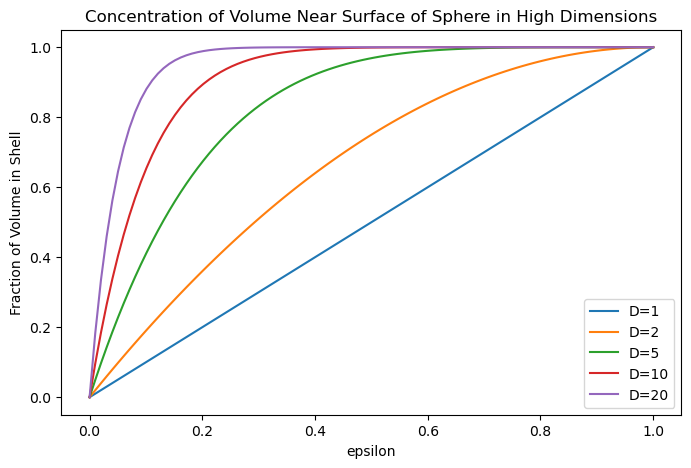

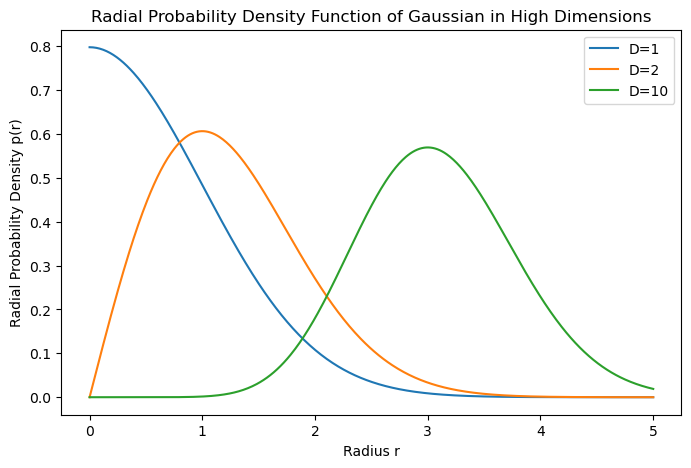

In [21]:
import math

#plot the fraction of volume in the shell as a function of dimensions
D_values = np.array([1, 2, 5, 10, 20])
epsilon = np.linspace(0, 1, 100)

fractions = 1 - (1 - epsilon) ** D_values[:, np.newaxis]
plt.figure(figsize=(8, 5))
for i, D in enumerate(D_values):
    plt.plot(epsilon, fractions[i], label=f'D={D}')
plt.xlabel("epsilon")
plt.ylabel("Fraction of Volume in Shell")
plt.title("Concentration of Volume Near Surface of Sphere in High Dimensions")
plt.legend()
plt.show()


#plot the radial probability density function for different dimensions
D_values = np.array([1, 2, 10])
r = np.linspace(0, 5, 500)
plt.figure(figsize=(8, 5))
for D in D_values:
    S_D = 2 * np.pi ** (D / 2) / math.gamma(D / 2)
    p_r = (1 / (2 * np.pi) ** (D / 2)) * np.exp(-r**2 / 2) * S_D * r**(D - 1)
    plt.plot(r, p_r, label=f'D={D}')
plt.xlabel("Radius r")
plt.ylabel("Radial Probability Density p(r)")
plt.title("Radial Probability Density Function of Gaussian in High Dimensions")
plt.legend()
plt.show()


# 1.5 Decision Theory

In this section, we study decision theory in which optimal decisions are made involving uncertainty. 

We consider an example that predict whether a patient has cancer or not based on input vector $\mathbf{x}$, the set of pixel intensities of X-ray images. The output variable $t$ is binary, where $t=0$ indicates the presence of cancer belong to class $C_1$ and $t=1$ indicates no cancer, belonging to class $C_2$. When we obtain a new image with input vector $\mathbf{x}$, we need to decide whether to classify it as $C_1$ or $C_2$. Using Bayes' theorem, we can compute the posterior probabilities for each class given the input vector $\mathbf{x}$:
\begin{equation*}
    p(C_k|\mathbf{x}) = \frac{p(\mathbf{x}|C_k)p(C_k)}{p(\mathbf{x})}
\end{equation*}
Note that all the quantities on the right-hand side can be estimated from the joint distribution $p(\mathbf{x}, C_k)$. If our aim is to minimize the probability of misclassification, we should assign the input vector $\mathbf{x}$ to the class with the highest posterior probability.

# 1.5.1 Minimizing the misclassification rate

We need a rule dividing the input space into two regions $R_1$ and $R_2$ called decision regions, such that if $\mathbf{x} \in R_k$, we assign it to class $C_k$. The boundary between these two regions is called the decision boundary. The probability of misclassification can be expressed as:

\begin{align*}
    p(\text{mistake}) &= p(\mathbb{x} \in R_1, C_2) + p(\mathbb{x} \in R_2, C_1) \\
        &= \int_{R_1} p(\mathbf{x}, C_2) d\mathbf{x} + \int_{R_2} p(\mathbf{x}, C_1) d\mathbf{x}
\end{align*}

Thus, to minimize $p(\text{mistake})$, we should choose the decision regions such that at each point $\mathbf{x}$, we assign it to the class with has smaller integrand or has the larger posterior probability $p(\mathbf{x} | C_k)$. Using the product rule, we can rewrite as $p(\mathbf{x}, C_k) = p(C_k|\mathbf{x}) p(\mathbf{x})$. Since $p(\mathbf{x})$ is common to both classes, we can minimize the probability of misclassification by assigning $\mathbf{x}$ to the class with the larger posterior probability $p(C_k|\mathbf{x})$.

For more general $K$-class classification problems, we can maximize the probability of correct classification:
\begin{align*}
    p(\text{correct}) &= \sum_{k=1}^{K} \int_{R_k} p(\mathbf{x}, C_k) d\mathbf{x}\\
        &= \sum_{k=1}^{K} \int_{R_k} p(C_k|\mathbf{x}) p(\mathbf{x}) d\mathbf{x}
\end{align*}

which is maximized by assigning each $\mathbf{x}$ to the class with the largest posterior probability $p(C_k|\mathbf{x})$. 

# 1.5.2 Minimizing the expected loss

In many practical applications, we may want to minimize the expected loss instead of just the misclassification rate. The expected loss is defined as:

\begin{equation*}
    \mathbf{E}(L) = \sum_{k=1}^{K} \sum_{j=1}^{K} \int_{R_j} L_{kj} p(\mathbf{x}, C_k) d\mathbf{x}
\end{equation*}

where $L(C_k, \mathbf{x})$ is the loss incurred for classifying $\mathbf{x}$ as $C_k$. The goal is to choose the decision regions $R_k$ to minimize the expected loss $\mathbf{E}(L)$.

# 1.5.3 The reject option

In some cases, it may be better to reject making a classification decision rather than risking a misclassification, especially when the largest value of the posterior probability is not significantly larger than the others. We can introduce a reject option a threshold $\theta$ such that if the largest posterior probability $p(C_k|\mathbf{x}) < \theta$, we reject making a decision for that input $\mathbf{x}$. This allows us to avoid making uncertain classifications and can be particularly useful in high-stakes applications where misclassifications can have serious consequences.

Note that setting $\theta = 1$ means we always reject making a decision, while setting $\theta < 1/K$ means we never reject and always make a classification decision. By adjusting the threshold $\theta$, we can control the trade-off between the misclassification rate and the rejection rate, allowing us to tailor the decision-making process to the specific requirements of the application at hand.


# 1.5.4 Inference and decision

We introduce a function that maps the input vector $\mathbf{x}$ to a decision $d$, called a discriminant function.

In fact, we can identify three distinct approaches to solving decision problems:

**a)** First solve the inference problem of determining the class-conditional densities $p(\mathbf{x}|C_k)$ and prior probabilities $p(C_k)$, and then use Bayes' theorem to compute the posterior probabilities $p(C_k|\mathbf{x})$:
    
\begin{equation*}
    p(C_k|\mathbf{x}) = \frac{p(\mathbf{x}|C_k)p(C_k)}{p(\mathbf{x})}
\end{equation*}

The denominator $p(\mathbf{x})$ can be found in terms of the quantities appearing in the numerator by using the sum rule:

\begin{equation*}
    p(\mathbf{x}) = \sum_{k=1}^{K} p(\mathbf{x}|C_k)p(C_k)
\end{equation*}

So we can model the joint distribution $p(\mathbf{x}, C_k)$ and normalize to obtain the posterior probabilities. Having obtained the posterior probabilities, we can use decision theory to make class assignments. This approach is known as the generative models, since by sampling from the distribution of each class, we can generate synthetic data points.

**b)** Alternatively, we can directly model the posterior probabilities $p(C_k|\mathbf{x})$ without going through the intermediate step of modeling the class-conditional densities and prior probabilities. This approach is known as discriminative models, since we are directly modeling the decision boundary between classes. Examples of discriminative models include logistic regression and support vector machines.

**c)** A third approach is to directly construct a mapping from the input vector $\mathbf{x}$ to a decision $d$ without explicitly modeling probabilities. This can be done using techniques such as decision trees or neural networks, which learn to make decisions based on patterns in the input data. This approach is often used in situations where the underlying probability distributions are complex or unknown, and we want to focus on making accurate decisions rather than modeling the full probabilistic structure of the data.

One advantage of apprioach (a) is that it allows us to determine the marginal distribution $p(\mathbf{x})$ of the input vector $\mathbf{x}$, which can be useful for tasks such as anomaly detection or outlier detection.

However if we only care about making accurate decisions, then approaches (b) and (c) may be more appropriate, as they focus directly on the decision-making process without the need to model the full probabilistic structure of the data.

There are many reasons for wanting to compute the posterior probabilities. These include:
- Minimizing risk: if we know the posterior probabilities, we can make decisions that minimize the risk decision criterion.
- Reject option: if we know the posterior probabilities, we can implement a reject option, minimizing the misclassification rate and expected loss.
- Compensating for class priors: for example, in medical diagnosis, the prevalence of a disease may be low, only 1 in 1000 people. A classifier that always predicts the absence of disease would achieve a high accuracy of 99.9%, but would be useless for detecting the disease. We may use a modified dataset with balanced class priors to train a more accurate classifier. But then, we need to compensate for the modified class priors when making predictions on real-world data. This can be done using Bayes' theorem to adjust the posterior probabilities based on the true class priors in the population.
- Combining models: in our medical diagnosis example, we may have many different types of tests, such as blood tests and imaging tests. Instead of combining all the information into a single model, we can train separate models on each type of data and then combine their predictions using the posterior probabilities. Assume that the distribution of $x_I$ (X-ray images) and $x_B$ (blood tests) are independen, so that:
\begin{equation*}
    p(x_I, x_B | C_k) = p(x_I | C_k) p(x_B | C_k)
\end{equation*}

The posterior probabilities from the two models can then be combined:
\begin{align*}
    p(C_k | x_I, x_B) & \propto p(x_I, x_B | C_k) p(C_k) \\ &\propto p(x_I | C_k) p(x_B | C_k) p(C_k)\\& \propto p(C_k | x_I) p(C_k | x_B) / p(C_k)
\end{align*}

The independence assumption is an example of the naive Bayes model. The joint distribution $p(x_I, x_B)$ will typically not factorize under this model.

1.5.5 Loss functions for regression

We have discussed loss functions for classification problems. Now we consider loss functions for regression problems, where $y(\mathbf{x})$ is an estimate of the target value $t$ for input vector $\mathbf{x}$. We can define a loss function $L(y(\mathbf{x}), t)$ that measures the cost of predicting $y(\mathbf{x})$ when the true target value is $t$. The expected loss for a given input vector $\mathbf{x}$ is then given by:

\begin{align*}
    \mathbf{E}[L] &= \int L(y(\mathbf{x}), t) p(\mathbf{x}, t) dt
\end{align*}

A common choice for the loss function is the squared loss:

\begin{equation*}
    L(y(\mathbf{x}), t) = (y(\mathbf{x}) - t)^2
\end{equation*}

So the expected squared loss becomes:

\begin{align*}
    \mathbf{E}[L] &= \int (y(\mathbf{x}) - t)^2 p(\mathbf{x}, t) dt
\end{align*}

We can minimize the expected squared loss by setting the functional derivative with respect to $y(\mathbf{x})$ (with the assumption that $y(\mathbf{x})$ is completely flexible) to zero:
\begin{align*}
    \frac{\partial \mathbf{E}[L]}{\partial y(\mathbf{x})} &= \int 2(y(\mathbf{x}) - t) p(\mathbf{x}, t) dt = 0
\end{align*}

Solve for $y(\mathbf{x})$, we obtain:
\begin{equation*}
    y(\mathbf{x}) = \frac{\int t p(\mathbf{x}, t) dt}{p(\mathbf{x})} = \int t p(t|\mathbf{x}) dt = \mathbb{E}_{t}[t|\mathbf{x}]
\end{equation*}

which is the conditional mean of the target variable $t$ given the input vector $\mathbf{x}$ and is known as the regression function.

Another way to derive this result is to note that:
\begin{align*}
    \left( y(\mathbf{x}) - t \right)^2 &= \left( y(\mathbf{x}) - \mathbb{E}[t|\mathbf{x}] + \mathbb{E}[t|\mathbf{x}] - t \right)^2 \\
    &= \left( y(\mathbf{x}) - \mathbb{E}[t|\mathbf{x}] \right)^2 + \left( \mathbb{E}[t|\mathbf{x}] - t \right)^2 + 2\left( y(\mathbf{x}) - \mathbb{E}[t|\mathbf{x}] \right)\left( \mathbb{E}[t|\mathbf{x}] - t \right)
\end{align*}

Plug this into the loss function and take integral over t:
\begin{align*}
    \mathbf{E}[L] &= \int \left( y(\mathbf{x}) - t \right)^2 p(t|\mathbf{x}) dt \\
    &= \int \left( y(\mathbf{x}) - \mathbb{E}[t|\mathbf{x}] \right)^2 p(t|\mathbf{x}) dt + \int \left( \mathbb{E}[t|\mathbf{x}] - t \right)^2 p(t|\mathbf{x}) dt + 2\left( y(\mathbf{x}) - \mathbb{E}[t|\mathbf{x}] \right) \int \left( \mathbb{E}[t|\mathbf{x}] - t \right) p(t|\mathbf{x}) dt \\
    &= \int \left( y(\mathbf{x}) - \mathbb{E}[t|\mathbf{x}] \right)^2 p(t|\mathbf{x}) dt + \int \left( \mathbb{E}[t|\mathbf{x}] - t \right)^2 p(t|\mathbf{x}) dt 
\end{align*}

Since $y(\mathbf{x})$ just involves the first term, we can minimize it by setting $y(\mathbf{x}) = \mathbb{E}[t|\mathbf{x}]$.

We can identify 3 approaches to solving regression problems:
    
(a) First solve the inference problem of determining the joint density $ p(\mathbf{x}, t) $. 
Then normalize to find the conditional density $ p(t \mid \mathbf{x}) $, 
and finally marginalize to find the conditional mean.

(b) First solve the inference problem of determining the conditional density $ p(t \mid \mathbf{x}) $,
and then subsequently marginalize to find the conditional mean.

(c) Find a regression function $ y(\mathbf{x}) $ directly from the training data.

The squared loss function is not the only possible choice for regression problems. There are situations where other loss functions may be more appropriate, such as the absolute loss function $ L(y(\mathbf{x}), t) = |y(\mathbf{x}) - t| $, which leads to the conditional median as the optimal regression function. We consider another example of Minskowski loss functions:
    
\begin{equation*}
    L_q(y(\mathbf{x}), t) = |y(\mathbf{x}) - t|^q
\end{equation*}

which then leads to the following expected loss:
\begin{align*}
    \mathbf{E}[L_q] &= \int |y(\mathbf{x}) - t|^q p(t|\mathbf{x}) dt
\end{align*}

For $q = 1$, we obtain the absolute loss function which leads to the conditional median as the optimal regression function. For $q \to 0$, we obtain the loss function:
\begin{equation*}
    L_0(y(\mathbf{x}), t) = \lim_{q \to 0} |y(\mathbf{x}) - t|^q = 
    \begin{cases}
    0, & \text{if } y(\mathbf{x}) = t \\
    1, & \text{if } y(\mathbf{x}) \neq t
    \end{cases}
\end{equation*}
which leads to the conditional mode as the optimal regression function.

# 1.6 Information theory

We introduce the concept of 'degree of surprise', which quantifies how unexpected an event is. An event that is highly improbable occurs gives us more information than an event that is very likely to happen. We therefore define the quantity $h(x) = -\log p(x)$ as the degree of surprise associated with the occurrence of an event $x$ with probability $p(x)$. The entropy $H$ of a discrete random variable $X$ with possible outcomes $\{x_1, x_2, \ldots, x_n\}$ and corresponding probabilities $\{p(x_1), p(x_2), \ldots, p(x_n)\}$ is defined as:
    
\begin{equation*}
    H(X) = -\sum_{i=1}^{n} p(x_i) \log p(x_i)
\end{equation*}

Note that $\lim_{p \to 0} p \log p = 0$, so events with zero probability do not contribute to the entropy. The entropy can be interpreted as the expected degree of surprise when observing an outcome of the random variable $X$.

To maximize the entropy under the constraints that the probabilities sum to one, we can use the method of Lagrange multipliers. We set up the functional:

\begin{equation*}
    \mathcal{L} = -\sum_{i=1}^{n} p(x_i) \log p(x_i) + \lambda \left( \sum_{i=1}^{n} p(x_i) - 1 \right)
\end{equation*}

Taking the derivative of the Lagrangian with respect to $ p(x_i) $ and setting it to zero gives:
    
\begin{equation*}
    \frac{\partial \mathcal{L}}{\partial p(x_i)} = -\log p(x_i) - 1 + \lambda = 0
\end{equation*}

Solving for $ p(x_i) $, we find:
    
\begin{equation*}
    p(x_i) = e^{\lambda - 1}
\end{equation*}

Since the probabilities must sum to one, we have:
    
\begin{equation*}
    \sum_{i=1}^{n} p(x_i) = n e^{\lambda - 1} = 1 \implies e^{\lambda - 1} = \frac{1}{n}
\end{equation*}

Thus, the maximum entropy distribution is the uniform distribution:
    
\begin{equation*}
    p(x_i) = \frac{1}{n}
\end{equation*}

Then, the maximum entropy is:

\begin{equation*}
    H_{\text{max}} = -\sum_{i=1}^{n} \frac{1}{n} \log \frac{1}{n} = \log n
\end{equation*}

To verify that this is indeed a maximum, we can examine the second derivative of the Lagrangian:
\begin{equation*}
    \frac{\partial^2 \mathcal{L}}{\partial p(x_i) \partial p(x_j)} = -I_{ij}\frac{1}{p(x_i)} 
\end{equation*}

where $ I_{ij} $ is the Kronecker delta. Since $ p(x_i) > 0 $, the second derivative is negative definite.

We extend the definition of entropy to continuous random variables. For a continuous random variable $X$ with probability density function $p(x)$, the differential entropy is defined as:

\begin{equation*}
    h(X) = -\int p(x) \log p(x) \, dx
\end{equation*}

We maximize the differential entropy under three constraints:
\begin{align*}
    \int p(x) \, dx &= 1 \\
    \int x p(x) \, dx &= \mu \\
    \int (x - \mu)^2 p(x) \, dx &= \sigma^2
\end{align*}

We perform the maximization using the method of Lagrange multipliers. We set up the functional:
    
\begin{equation*}
    \mathcal{L(p(x))} = -\int p(x) \log p(x) \, dx + \lambda_1 \left( \int p(x) \, dx - 1 \right) + \lambda_2 \left( \int x p(x) \, dx - \mu \right) + \lambda_3 \left( \int (x - \mu)^2 p(x) \, dx - \sigma^2 \right)
\end{equation*}

Taking the functional derivative with respect to $p(x)$ in detail, we have:

\begin{equation*}
    \frac{\delta \mathcal{L}}{\delta p(x)} = -\log p(x) - 1 + \lambda_1 + \lambda_2 x + \lambda_3 (x - \mu)^2 = 0
\end{equation*}

Or equivalently:

\begin{equation*}
    p(x) = \exp \left( \lambda_1 - 1 + \lambda_2 x + \lambda_3 (x - \mu)^2 \right)
\end{equation*}

Substituting back, we find that the probability density function that maximizes the differential entropy under the given constraints is the Gaussian distribution:
    
\begin{equation*}
    p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x - \mu)^2}{2 \sigma^2} \right)
\end{equation*}

Then we can evaluate the differential entropy for the Gaussian distribution:

\begin{align*}
    h(X) &= -\int p(x) \log p(x) \, dx \\
    &= -\int \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x - \mu)^2}{2 \sigma^2} \right) \left( -\frac{(x - \mu)^2}{2 \sigma^2} - \frac{1}{2} \log (2 \pi \sigma^2) \right) dx \\
    &= \frac{1}{2} + \frac{1}{2} \log (2 \pi \sigma^2)
\end{align*}

The conditional entropy of a random variable $Y$ given another random variable $X$ is defined as:

\begin{equation*}
    H(Y|X) = -\int \int p(x, y) \log p(y|x) \, dx \, dy
\end{equation*}

From the product rule, we get:
    
\begin{equation*}
    H(X, Y) = H(X) + H(Y|X)
\end{equation*}

where $H(X,Y)$ is the differential entropy of the joint distribution $p(x,y)$ and $H(X)$ is the differential entropy of the marginal distribution $p(x)$.

# 1.6.1 Relative entropy and mutual information

If we use a distribution $q(x)$ to approximate a true distribution $p(x)$, the additional amount of information required to code samples from $p(x)$ using a code optimized for $q(x)$ rather than one optimized for $p(x)$ is given by the relative entropy or Kullback-Leibler divergence:

\begin{equation*}
    D_{KL}(p \| q) = \int p(x) \log \frac{p(x)}{q(x)} \, dx
\end{equation*}

This quantity is always non-negative and is zero if and only if $p(x) = q(x)$ almost everywhere.

To show this, we can use Jensen's inequality. Since the logarithm is a concave function, we have:

\begin{equation*}
    \int p(x) \log \frac{q(x)}{p(x)} \, dx \leq \log \left( \int p(x) \frac{q(x)}{p(x)} \, dx \right) = \log 1 = 0
\end{equation*}

Since $-\log x$ is strictly convex, the equality holds if and only if $p(x) = q(x)$ for all $x$.

Suppose that data is generated from a true distribution $p(x)$, but we model it using a parametric family of distributions $q(x|\theta)$. We can choose the parameters $\theta$ to minimize the relative entropy between the true distribution and our model:

\begin{equation*}
    D_{KL}(p \| q) \simeq \sum_{n=1}^{N} \log \frac{p(x_n)}{q(x_n|\theta)} = -\sum_{n=1}^{N} \log q(x_n|\theta) + \text{constant}
\end{equation*}

Minimizing the relative entropy is equivalent to maximizing the log-likelihood function of the model $q(x|\theta)$ given the observed data $\{x_n\}_{n=1}^{N}$.

Now, we consider the joint distribution of two random variables $X$ and $Y$. The mutual information between $X$ and $Y$ is defined as:

\begin{equation*}
    I(X; Y) = D_{KL}(p(x, y) \| p(x)p(y)) = H(X) + H(Y) - H(X, Y)
\end{equation*}

where $H(X)$ and $H(Y)$ are the marginal entropies and $H(X, Y)$ is the joint entropy.
